This is practically copied from the following:
* [How to do Deep Learning on Graphs with Graph Convolutional Networks - Tobias Jepsen](https://towardsdatascience.com/how-to-do-deep-learning-on-graphs-with-graph-convolutional-networks-7d2250723780)  

Tobias was inspired by this post:
* [Graph Convolutional Networks - Thomas Kipf](http://tkipf.github.io/graph-convolutional-networks/)

# Basics of Graph convolutions

## Setting it up

To define a graph with nodes (with features) and vertices, we need two matrices. We need a way to define which node is connected to which other node with an adjecency matrix `A`. We also need a feature matrix where the features of each nodes are defined with matrix `X`

In [1]:
import numpy as np

In [2]:
A = np.matrix([
    [0, 1, 0, 0],
    [0, 0, 1, 1],
    [0, 1, 0, 0],
    [1, 0, 1, 0]
])

In [3]:
X = np.matrix([
    [ 0.,  0.],
    [ 1., -1.],
    [ 2., -2.],
    [ 3., -3.]
])

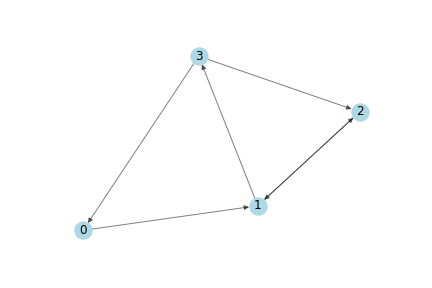

In [4]:
from IPython.display import Image
Image(filename='graph.png',width=400, height=200)

The graph gets the value from the locations where the arrows point at.

To propagate the information one step `A` and `X` need to be multiplied.

In [5]:
A * X

matrix([[ 1., -1.],
        [ 5., -5.],
        [ 1., -1.],
        [ 2., -2.]])

Currently, the information that is in the node before the propagation step is lost. Now add the Identity matrix to `A` to not loose the original feature matrix.

In [6]:
A_hat = A + np.eye(A.shape[0])
A_hat

matrix([[1., 1., 0., 0.],
        [0., 1., 1., 1.],
        [0., 1., 1., 0.],
        [1., 0., 1., 1.]])

In [7]:
A_hat * X

matrix([[ 1., -1.],
        [ 6., -6.],
        [ 3., -3.],
        [ 5., -5.]])

Nodes with many connections will explode and nodes with few connections will vanish, this calls for normalization. Intuitively, nodes with many connections should have connections that are smaller in size. This is exactly what the 'inverse degree matrix' does. It is multiplied with the adjecency matrix to get a scaled adjecency matrix.

In [8]:
D_hat = np.array(np.sum(A_hat, axis=0))[0]
# D = array([2., 3., 3., 2.])
D_hat = np.matrix(np.diag(D_hat))
print('D_hat**-1:\n', D_hat**-1, '\n')
print('D_hat**-1 * A: \n', D_hat**-1 * A)

D_hat**-1:
 [[0.5        0.         0.         0.        ]
 [0.         0.33333333 0.         0.        ]
 [0.         0.         0.33333333 0.        ]
 [0.         0.         0.         0.5       ]] 

D_hat**-1 * A: 
 [[0.         0.5        0.         0.        ]
 [0.         0.         0.33333333 0.33333333]
 [0.         0.33333333 0.         0.        ]
 [0.5        0.         0.5        0.        ]]


Propagation with the normalized adjecency matrix then looks as follows:

In [9]:
D_hat**-1 * A_hat * X

matrix([[ 0.5, -0.5],
        [ 2. , -2. ],
        [ 1. , -1. ],
        [ 2.5, -2.5]])

In the next step we'll add weights. The weight matrix determines the dimension of the next 'layer'.

In [10]:
W_2 = np.matrix([
    [1, -1],
    [-1, 1]
])

In [11]:
D_hat**-1 * A_hat * X * W_2

matrix([[ 1., -1.],
        [ 4., -4.],
        [ 2., -2.],
        [ 5., -5.]])

Now try the same with a weigth matrix that reduces the dimensionality.

In [12]:
W_1 = np.matrix([
    [1],
    [-1]
])

In [13]:
D_hat**-1 * A_hat * X * W_1

matrix([[1.],
        [4.],
        [2.],
        [5.]])

Adding relu:

In [14]:
def relu(M):
    return np.maximum(M, 0)

In [15]:
relu(D_hat**-1 * A_hat * X * W_2)

matrix([[1., 0.],
        [4., 0.],
        [2., 0.],
        [5., 0.]])

## Applying the basics to a 'real' graph

Run `!pip install networkx` in the notebook to install the networkx library.

In [16]:
from networkx import to_numpy_matrix
from networkx import karate_club_graph
import matplotlib.pyplot as plt
%matplotlib inline

The karate_club_graph is a list of nodes with connections to those nodes. The adjecency matrix is symmetric so it is an undirected graph.

In [17]:
zkc = karate_club_graph()
order = sorted(list(zkc.nodes()))

A = to_numpy_matrix(zkc, nodelist=order)
I = np.eye(zkc.number_of_nodes())

In [18]:
# Is the transpose of A similar to A?
np.allclose(A, A.T, atol=0.001)

True

In [19]:
A_hat = A + I
D_hat = np.array(np.sum(A_hat, axis=0))[0]
D_hat = np.matrix(np.diag(D_hat))

Weights are randomly initiated because glove.

In [20]:
W_1 = np.random.normal(
    loc=0, scale=1, size=(zkc.number_of_nodes(), 4))
W_2 = np.random.normal(
    loc=0, size=(W_1.shape[1], 2))

The features are initialized as the Identity matrix; with features of length number_of_nodes where each node has feature of it's own index. The weights than transform it from number_of_nodes --> 4 --> 2.

In [21]:
def gcn_layer(A_hat, D_hat, X, W):
    return relu(D_hat**-1 * A_hat * X * W)

H_1 = gcn_layer(A_hat, D_hat, I, W_1)
H_2 = gcn_layer(A_hat, D_hat, H_1, W_2)

output = H_2

In [22]:
feature_representations = {
    node: np.array(output)[node] 
    for node in zkc.nodes()}

In [23]:
feature_list = np.asarray([feature_representations[i][:] for i 
                in feature_representations.keys()])

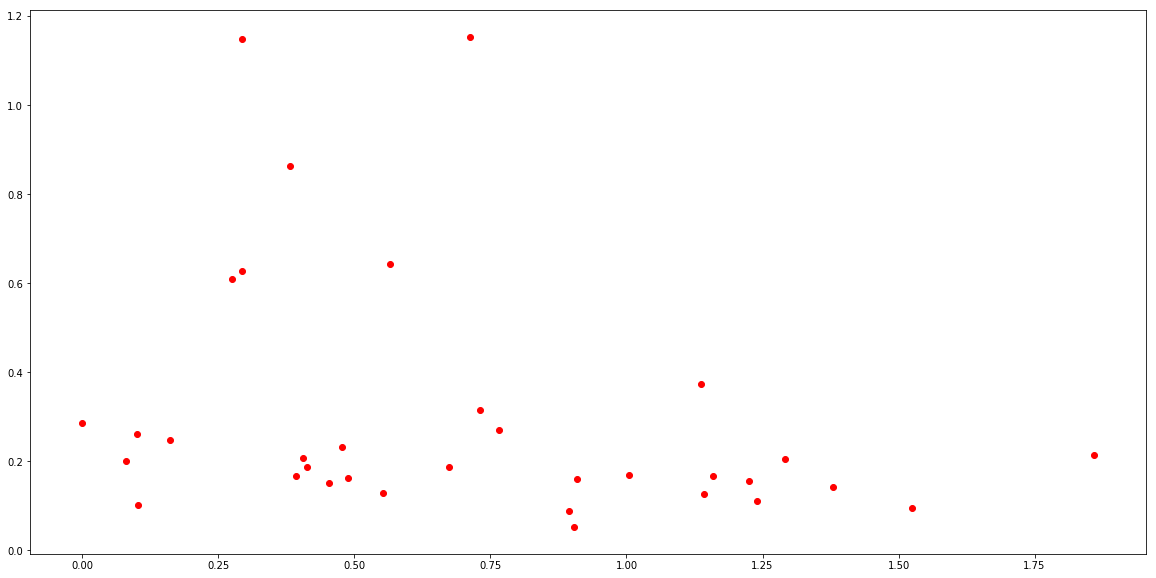

In [25]:
plt.figure(figsize=(20,10))
plt.scatter(feature_list[:,0], feature_list[:,1], c='r')

# Semi-supervised learning with spectral graph convolutions

## Recap and spectral weighing

As discussed in the basics, there are two measures to increase the performance of the model, adding the identity matrix to the adjecency matrix to also add the feature vector of the node itself, and a normalization step to reduce exploding/vanishing feature vectors. The normalization works as an inverse multiplication with the number of connections to other nodes.

Currently, a propagation step for node $\mathbf{i}$ looks like this:  
$$f(\mathbf{H^i, A}) = \sigma(\mathbf{D^{-1}\hat{A}H^i W^i})$$  
Intuitively, one propagation step can be thought of as consisting of two steps;  
* an aggregation of the features of the node and it's neighbours: $$aggregate(\mathbf{A, H^i}) = \mathbf{D^{-1}\hat{A}H^i} = \mathbf{M}$$
* a transformation of the features according to some weight matrix:
$$transform(\mathbf{M, W^i}) = \sigma(\mathbf{MW^i})$$  

In the Kipf paper a new aggregations step is proposed; a spectral aggregation step. The difference with the previous normalization is that now the adjecency matrix is scaled by the inverse squared root of the number of connections to the current node but also by the inverse squared of the number of connections to that individual connected node.

In other words; nodes with many neighbours are scaled down and neighbouring nodes are scaled down if they have many neighbourse. This might be useful if low-degree nodes provide more usefull information.

## Semi supervised classification with GCNs

In [26]:
import torch